### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-12-07 15:47:10--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2024-12-07 15:47:10 (59.3 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 45, 76, ..., 59, 49,  1],
       [83, 58, 50, ...,  0, 62, 68],
       [83, 45, 62, ..., 59, 54,  1],
       ...,
       [83, 60, 50, ...,  0, 63, 45],
       [83, 63, 73, ...,  7,  0, 55],
       [83,  1, 60, ...,  1, 56, 64]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
# your beautiful experiments here

In [8]:
def generate_batches(text_encoded, batch_size, seq_length, device=device):
    max_start_index = len(text_encoded) - batch_size * (seq_length + 1)
    start_index = np.random.randint(0, max_start_index)
    data = np.array(text_encoded[start_index:start_index + batch_size * (seq_length + 1)])
    data = data.reshape((batch_size, seq_length + 1))

    X_batch = data[:, :-1]
    Y_batch = data[:, 1:]

    return torch.tensor(X_batch, dtype=torch.long).to(device), torch.tensor(Y_batch, dtype=torch.long).to(device)
class CharRNN(nn.Module):
    def __init__(self, num_tokens, hidden_size, num_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_tokens = num_tokens

        self.embedding = nn.Embedding(num_tokens, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size, device=device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
# Hyperparameters
num_epochs = 20
batch_size = 256
seq_length = 100
hidden_size = 128
num_layers = 1
learning_rate = 0.005

# Initialize the model, loss function, and optimizer
char_rnn = CharRNN(num_tokens, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(char_rnn.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    char_rnn.train()

    # Generate batches
    X_batch, Y_batch = generate_batches(text_encoded, batch_size, seq_length, device)
    hidden = char_rnn.init_hidden(batch_size)

    optimizer.zero_grad()
    outputs, hidden = char_rnn(X_batch, hidden)

    # Reshape outputs and targets for the loss function
    outputs = outputs.reshape(-1, num_tokens)
    Y_batch = Y_batch.reshape(-1)

    loss = criterion(outputs, Y_batch)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/20], Loss: 3.1980
Epoch [10/20], Loss: 2.8360
Epoch [15/20], Loss: 2.7195
Epoch [20/20], Loss: 2.5967


В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

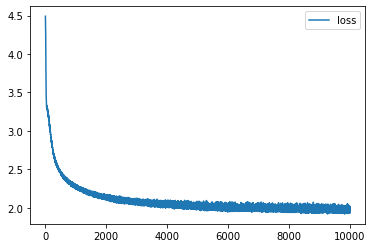

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [9]:
# Adjusted generate_sample function
def generate_sample(char_rnn, seed_phrase=' мой дядя самых честных правил', total_length=500, temperature=1.0, device=device):
    '''
    Generates text of a specified total length, including the seed_phrase.
    :param total_length: Total desired length of the output text.
    '''
    char_rnn.eval()

    if seed_phrase is not None:
        seed_tokens = [token_to_idx.get(token, token_to_idx[' ']) for token in seed_phrase]
        x_sequence = [token_to_idx['<sos>']] + seed_tokens
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # Initialize hidden state
    hidden = char_rnn.init_hidden(1)

    # Feed the seed phrase
    for i in range(len(x_sequence) - 1):
        _, hidden = char_rnn(x_sequence[:, i].unsqueeze(1), hidden)

    input_char = x_sequence[:, -1].unsqueeze(1)
    generated_sequence = x_sequence.cpu().data.numpy().tolist()[0][1:]  # Exclude <sos>

    # Calculate the number of characters to generate
    num_chars_to_generate = total_length - len(generated_sequence)

    # Generate the rest of the sequence
    for _ in range(num_chars_to_generate):
        output, hidden = char_rnn(input_char, hidden)
        output_dist = output.squeeze().div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        generated_sequence.append(top_i.item())
        input_char = top_i.unsqueeze(0).unsqueeze(1).to(device)

    # Convert indices to characters
    generated_text = ''.join([idx_to_token[ix] for ix in generated_sequence])
    return generated_text




Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [10]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

NameError: name 'model' is not defined

### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [11]:
seed_phrase = ' мой дядя самых честных правил'

In [12]:
generated_phrases = []

for _ in range(10):
    generated_text = generate_sample(
    char_rnn,
    seed_phrase=seed_phrase,
    total_length=500,  # Desired total length of the output text
    temperature=0.8,
    device=device
)
# Remove any technical tokens if present
generated_text = generated_text.replace('<sos>', '')
generated_phrases.append(generated_text)

generated_phrase = '\n\n'.join(generated_phrases)

In [13]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!